# 利用fbprophet预测新冠疫情期间的供水总量论文

**2020年3月1日prophet预测三月供水总量**

In [6]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
mpl.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime as dt

In [32]:

sup_water = pd.read_excel(r'C:/Users/Jay/mypyworks/自来水数据/2015-2020日供水总量.xlsx')

In [33]:
sup_water

,QUOTA_DATE,最低温度,最高温度,水厂供水总量
0,2015-01-01,15.0,21.0,3941482.0
1,2015-01-02,6.0,20.0,3903494.0
2,2015-01-03,13.0,21.0,4055444.0
3,2015-01-04,8.0,22.0,4077068.0
4,2015-01-05,16.0,23.0,4062857.0
...,...,...,...,...
1914,2020-03-29,15.0,19.0,3971552.0
1915,2020-03-30,13.0,18.0,3993176.0
1916,2020-03-31,13.0,15.0,3994162.0
1917,2020-04-01,13.0,17.0,4051907.0


In [34]:
#设置数据集
sup_water = sup_water.set_index('QUOTA_DATE').sort_index()['2015':]

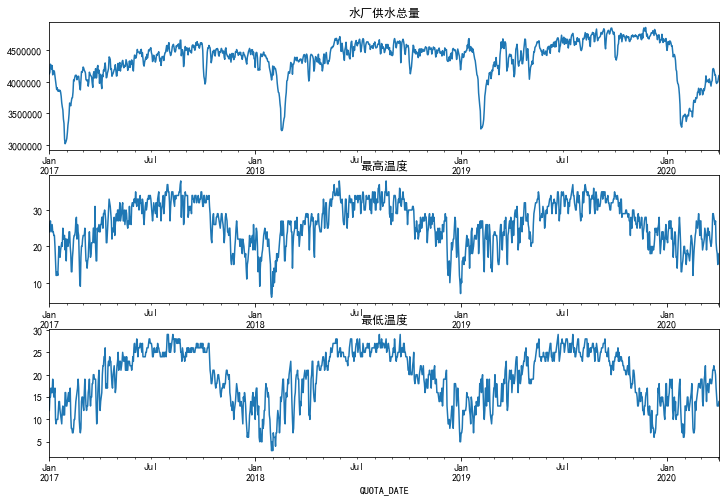

In [10]:
plt.figure(figsize=(12,8))
plt.subplot(311)
sup_water['水厂供水总量'].plot(title='水厂供水总量')
plt.subplot(312)
sup_water['最高温度'].plot(title='最高温度') 
plt.subplot(313)
sup_water['最低温度'].plot(title='最低温度')

In [ ]:
#判断缺失值
# sup_water[sup_water.isnull().any(axis=1)]

# np.isinf(sup_water['最高温度']).value_counts()

#判断数据框里面所有不是有限数据的数，可以排除null，np.nan,np.inf
sup_water[~(np.isfinite(sup_water).all(axis=1))]

In [ ]:
#判断离群值
# print(sup_water['最高温度'].value_counts(dropna=False))
am = sup_water['最高温度'].rolling(window=3,min_periods=0,center=True).mean()
diff = sup_water['最高温度'].values-am

# plt.figure(figsize=(12,8))
# plt.scatter(data = sup_water, x= sup_water.index.values,
#          y = '最低温度', 
#          marker='.',label='最低温度')
# plt.plot(sup_water.index.values,sup_water['上限'],'r--',label='离群上限')
# plt.plot(sup_water.index.values,sup_water['下限'],'r--',label='离群下限')
# plt.legend(loc='best')
# plt.title("动态判断时间序列的离群值")

sup_water.loc[diff.abs()>diff.std(ddof=0)*4,].sort_values('最高温度')

In [ ]:
sup_water.eval("平均温度=(最高温度+最低温度)/2",inplace=True)

In [ ]:
sup_water

**按照多项式处理来看各指标的相关性**

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=3,include_bias=1)
X_poly = poly_features.fit_transform(sup_water[['最低温度','最高温度','平均温度']])

#将poly数组转化程dataframe画相关矩阵，np也有相关矩阵函数，但带列名更加清楚。
sup_water_poly= pd.DataFrame(data=X_poly,columns=poly_features.get_feature_names())

sup_water_poly['水厂供水总量'] = sup_water['水厂供水总量'].values

sup_water_poly.corrwith(sup_water_poly['水厂供水总量']).sort_values(ascending=False)

**从上面结果来看最高温的相关性最高**

In [ ]:
#pd还提供做相关矩阵和相关性图的函数，但因为指标太多，因此省去。
# sup_water.corr()
# pd.plotting.scatter_matrix(sup_water,figsize=(12,8),alpha=0.2)

## **正式运用模型**

In [35]:
sup_water_fp=sup_water.reset_index()[['QUOTA_DATE','水厂供水总量','最高温度']].rename(columns={'QUOTA_DATE':'ds','水厂供水总量':'y'})

In [204]:
# sup_water_fp['y'] = np.log(sup_water_fp['y'])

In [205]:
cap = 5050000
sup_water_fp['cap']= cap

In [206]:
# import borax

In [36]:
import sxtwl
lunar = sxtwl.Lunar()


In [37]:
guoqing = pd.DataFrame({
  'holiday': 'guoqing',
  'ds': pd.date_range(start= '2015-10-1',periods=6,freq='AS-OCT'),
  'lower_window': 0,
  'upper_window': 6,
})

spring_date=[]
for i in list(range(2014,2020)):
    solar_day = lunar.getDayByLunar(i,12,30)
    solar_date = dt.date(solar_day.y, solar_day.m, solar_day.d)
    spring_date.append(solar_date)
    
spring = pd.DataFrame({
  'holiday': 'spring',
  'ds':spring_date,
  'lower_window': -14,
  'upper_window': 14,
})

covid1 = pd.DataFrame({
  'holiday': 'covid1',
  'ds':pd.date_range(start= '2020-1-23',end='2020-2-23'),
  'lower_window': 0,
  'upper_window': 0,
})

covid2 = pd.DataFrame({
  'holiday': 'covid2',
  'ds':pd.date_range(start= '2020-2-24',end='2020-4-30'),
  'lower_window': 0,
  'upper_window': 0,
})
holidays = pd.concat((guoqing, spring,covid1,covid2))

In [38]:
holidays

,holiday,ds,lower_window,upper_window
0,guoqing,2015-10-01 00:00:00,0,6
1,guoqing,2016-10-01 00:00:00,0,6
2,guoqing,2017-10-01 00:00:00,0,6
3,guoqing,2018-10-01 00:00:00,0,6
4,guoqing,2019-10-01 00:00:00,0,6
...,...,...,...,...
62,covid2,2020-04-26 00:00:00,0,0
63,covid2,2020-04-27 00:00:00,0,0
64,covid2,2020-04-28 00:00:00,0,0
65,covid2,2020-04-29 00:00:00,0,0


In [39]:
sup_water_fp

,ds,y,最高温度
0,2015-01-01,3941482.0,21.0
1,2015-01-02,3903494.0,20.0
2,2015-01-03,4055444.0,21.0
3,2015-01-04,4077068.0,22.0
4,2015-01-05,4062857.0,23.0
...,...,...,...
1914,2020-03-29,3971552.0,19.0
1915,2020-03-30,3993176.0,18.0
1916,2020-03-31,3994162.0,15.0
1917,2020-04-01,4051907.0,17.0


In [91]:
#initial=三（10=-1），period=7天，cv=10折，horizon=31天
7*(10-1)+365*3+31+1
# dt.date(2020,4,2)-dt.timedelta(days = 31)

1190

In [48]:
sup_water_train = sup_water_fp[-1190:]
# sup_water_test = sup_water_fp[-31:]

In [92]:
sup_water_train

,ds,y,最高温度
729,2016-12-30,4204403.0,19.0
730,2016-12-31,4190432.0,23.0
731,2017-01-01,4125192.0,24.0
732,2017-01-02,4149662.0,26.0
733,2017-01-03,4276621.0,27.0
...,...,...,...
1914,2020-03-29,3971552.0,19.0
1915,2020-03-30,3993176.0,18.0
1916,2020-03-31,3994162.0,15.0
1917,2020-04-01,4051907.0,17.0


In [ ]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore") 
def rmse(df):
            return np.sqrt(mean_squared_error(df['y'],df['yhat']))
df1 = pd.DataFrame(columns=('param',  'rmse'))
i = 0
while i<20:
    try:
        # 参数搜索
        changepoint_range = round(np.random.uniform(0.8,0.96),2) 
        changepoint_prior_scale = round(np.random.uniform(0.05,0.51),2)
        holidays_prior_scale = round(np.random.uniform(0.1,10.1),1)
        yearly_fourier_order = np.random.randint(1,11)
        weekly_prior_scale = round(np.random.uniform(0.1,10.1),1)
        yearly_prior_scale = round(np.random.uniform(0.1,10.1),1)
        regressor_prior_scale = round(np.random.uniform(0.1,10.1),1)
        param={'ch_range':changepoint_range,'ch_ps':changepoint_prior_scale,'holi_ps':holidays_prior_scale,
                      'weekly_ps':weekly_prior_scale,'yearly_forder':yearly_fourier_order,'yearly_ps':yearly_prior_scale,
                      'regressor_ps':regressor_prior_scale}
        m = Prophet(holidays=holidays,
            n_changepoints = 25,
            changepoint_range=changepoint_range,
            changepoint_prior_scale=changepoint_prior_scale,
            holidays_prior_scale=holidays_prior_scale)
        m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=weekly_prior_scale)
        m.add_seasonality(name='yearly', period=365.25, fourier_order=yearly_fourier_order, prior_scale=yearly_prior_scale)
        m.add_regressor('最高温度',prior_scale=regressor_prior_scale)
        m.fit(sup_water_train)

        df_cv = cross_validation(m, initial='1095 days', period='7 days', horizon = '31 days') 
        rmse = df_cv.groupby('cutoff').apply(rmse).mean()
        df1.loc[i] = [param,rmse]
        i+=1            
    except:
        continue
df1.sort_values(['rmse']).head(10)

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-12-30 00:00:00 and 2020-03-02 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-12-30 00:00:00 and 2020-03-02 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-12-30 00:00:00 and 2020-03-02 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-12-30 00:00:00 and 2020-03-02 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-12-30 00:00:00 and 2020-03-02 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprop

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-12-30 00:00:00 and 2020-03-02 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-12-30 00:00:00 and 2020-03-02 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-12-30 00:00:00 and 2020-03-02 00:00:00
INFO:f

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-12-30 00:00:00 and 2020-03-02 00:00:00


In [50]:
m = Prophet(holidays=holidays,
            n_changepoints = 25,
            changepoint_range=0.95,
            changepoint_prior_scale=0.5,
#             yearly_seasonality=10,
#             seasonality_prior_scale=10,
            holidays_prior_scale=10)
m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=10)
m.add_seasonality(name='yearly', period=365.25, fourier_order=10, prior_scale=10)
m.add_regressor('最高温度',prior_scale=10)
m.fit(sup_water_train)

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [51]:
# #交叉验证
# from fbprophet.diagnostics import cross_validation
# from sklearn.metrics import mean_squared_error
# df_cv = cross_validation(m, initial='1095 days', period='7 days', horizon = '31 days')
# # df_cv[['yhat','yhat_lower','yhat_upper','y']] = np.exp(df_cv[['yhat','yhat_lower','yhat_upper','y']])

# def rmse(df):
#     return np.sqrt(mean_squared_error(df['y'],df['yhat']))

# df_cv.groupby('cutoff').apply(rmse).mean()

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-12-30 00:00:00 and 2020-03-02 00:00:00


334574.41008721694

In [533]:
# help(Prophet)

Help on class Prophet in module fbprophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear' or 'logistic' to specify a linear or logistic
 |      trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_changepoints potential changepoints are selected uniforml

In [519]:
m.changepoints_t

array([0.03201348, 0.06402696, 0.09604044, 0.12805392, 0.1600674 ,
       0.19208088, 0.22409436, 0.25610783, 0.28812131, 0.32013479,
       0.35214827, 0.38416175, 0.41533277, 0.44734625, 0.47935973,
       0.51137321, 0.54338669, 0.57540017, 0.60741365, 0.63942713,
       0.67144061, 0.70345409, 0.73546757, 0.76748104, 0.79949452])

In [587]:
# df_cv.query("cutoff ==  '2020-03-02'")

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
310,2020-03-03,3.816630e+06,3.728276e+06,3.906475e+06,3859088.0,2020-03-02
311,2020-03-04,3.770359e+06,3.681961e+06,3.862289e+06,3792728.0,2020-03-02
312,2020-03-05,3.786678e+06,3.697611e+06,3.877377e+06,3810650.0,2020-03-02
313,2020-03-06,3.792683e+06,3.702115e+06,3.877496e+06,3887884.0,2020-03-02
314,2020-03-07,3.765668e+06,3.675251e+06,3.851900e+06,3858536.0,2020-03-02
315,2020-03-08,3.809749e+06,3.719417e+06,3.899867e+06,3904197.0,2020-03-02
316,2020-03-09,3.829787e+06,3.743563e+06,3.919458e+06,3963743.0,2020-03-02
317,2020-03-10,3.810678e+06,3.719884e+06,3.908085e+06,4092148.0,2020-03-02
318,2020-03-11,3.741136e+06,3.645804e+06,3.829680e+06,3999296.0,2020-03-02
319,2020-03-12,3.779846e+06,3.687041e+06,3.864994e+06,4002330.0,2020-03-02


In [ ]:
# from fbprophet.diagnostics import performance_metrics
# df_p = performance_metrics(df_cv)
# df_p

In [24]:
future = m.make_future_dataframe(periods=17)
future 

,ds
0,2017-01-01
1,2017-01-02
2,2017-01-03
3,2017-01-04
4,2017-01-05
...,...
1200,2020-04-15
1201,2020-04-16
1202,2020-04-17
1203,2020-04-18


In [25]:
# future['cap'] = cap
future['最高温度'] = np.r_[sup_water_fp['最高温度'].values,
                       np.array([21,19,18,18,22,24,24,24,23,24,23,23,29,29,26,27,26])]

In [26]:
print(future)
forecast = m.predict(future)

             ds  最高温度
0    2017-01-01  24.0
1    2017-01-02  26.0
2    2017-01-03  27.0
3    2017-01-04  24.0
4    2017-01-05  25.0
...         ...   ...
1200 2020-04-15  29.0
1201 2020-04-16  29.0
1202 2020-04-17  26.0
1203 2020-04-18  27.0
1204 2020-04-19  26.0

[1205 rows x 2 columns]


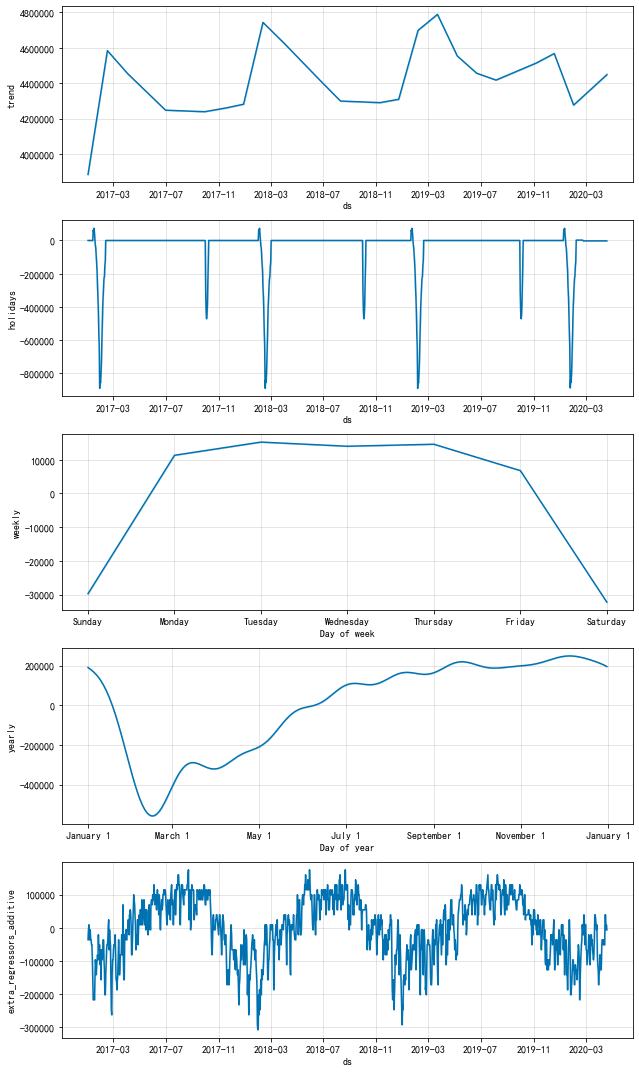

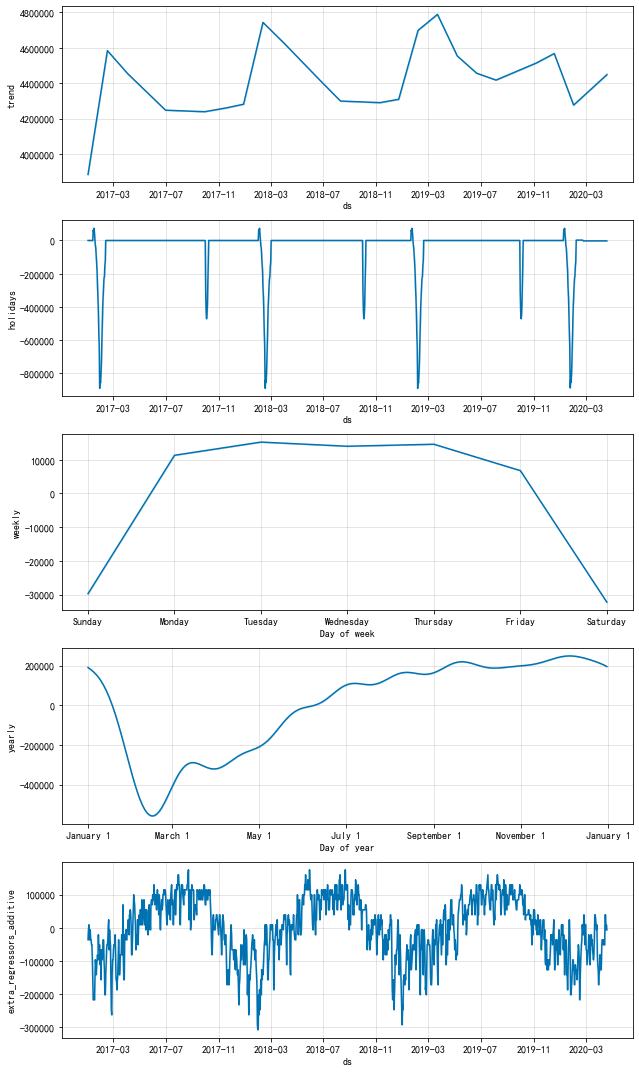

In [27]:
m.plot_components(forecast)

In [28]:
forecast.tail(20)[['ds','yhat']]

,ds,yhat
1185,2020-03-31,3.924277e+06
1186,2020-04-01,3.956423e+06
1187,2020-04-02,3.975963e+06
1188,2020-04-03,4.017926e+06
1189,2020-04-04,3.953755e+06
1190,2020-04-05,3.946785e+06
1191,2020-04-06,3.993996e+06
1192,2020-04-07,4.064874e+06
1193,2020-04-08,4.100719e+06
1194,2020-04-09,4.108438e+06


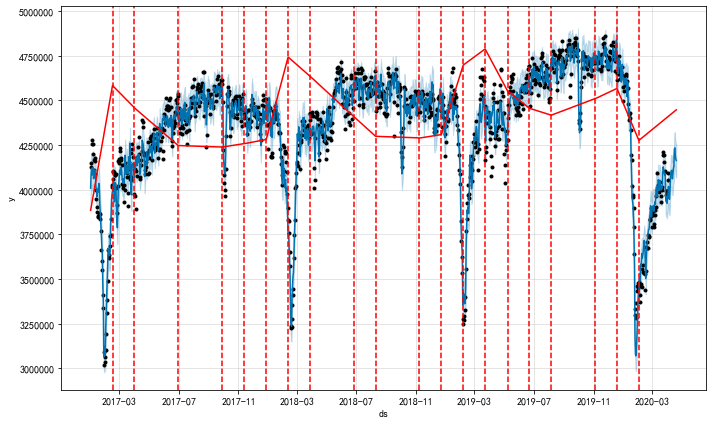

In [29]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

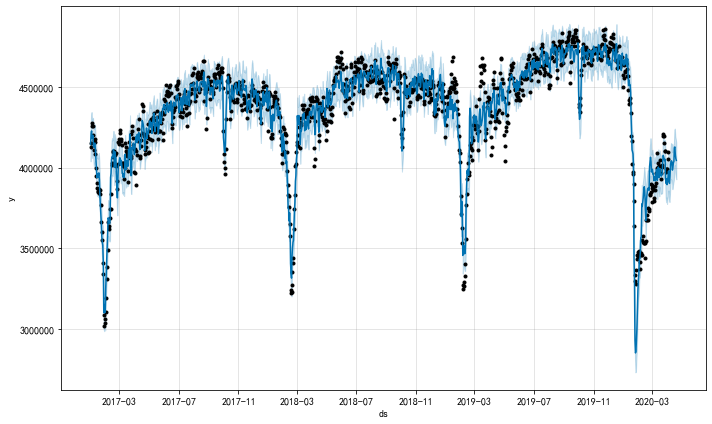

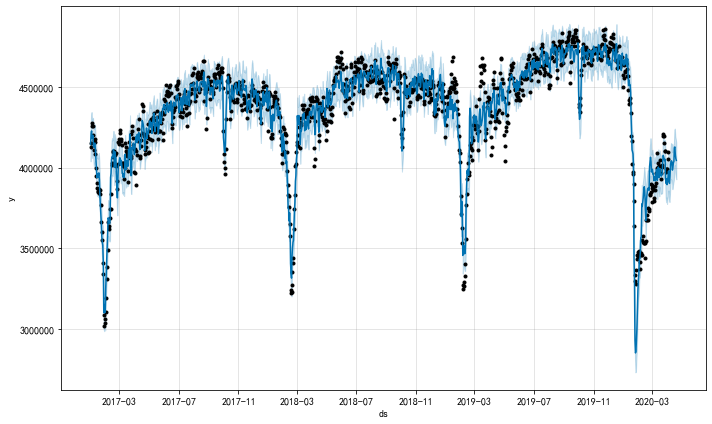

In [570]:
m.plot(forecast)

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][forecast['ds']>dt.date(2020,2,27)]

In [ ]:
m.plot(forecast)
m.plot_components(forecast)

In [ ]:
yhat=np.array(m.predict(test)['yhat'])
y=np.array(test['y'])
print(np.mean(np.abs((y-yhat)/y))) 
print(np.sqrt(np.sum((y-yhat)**2)/len(y)) )

In [ ]:
forecast[['ds', 'yhat']]

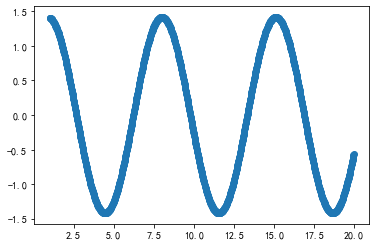

In [445]:
x=np.linspace(1, 20, 1000)
plt.scatter(x,(1*np.sin(6.18/7*x)+1*np.cos(6.18/7*x)))

